In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## LOAD DATA

In [ ]:
import kagglehub

path = kagglehub.dataset_download("purusinghvi/email-spam-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/email-spam-classification-dataset


In [ ]:
import os

dataset_path = "/kaggle/input/email-spam-classification-dataset"
print(os.listdir(dataset_path))

['combined_data.csv']


In [ ]:
import pandas as pd

file_path = f"{dataset_path}/combined_data.csv"
df = pd.read_csv(file_path)
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


## EDA & PREPROCESSING

In [ ]:
print('Missing value:')
print(df.isnull().sum())

print('\n\nData duplikat:')
print(df.duplicated().sum())

Missing value:
label    0
text     0
dtype: int64


Data duplikat:
0


In [ ]:
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())
print(f"Class distribution:\n{df['label'].value_counts()}")

Dataset shape: (83448, 2)
   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None
Class distribution:
label
1    43910
0    39538
Name: count, dtype: int64


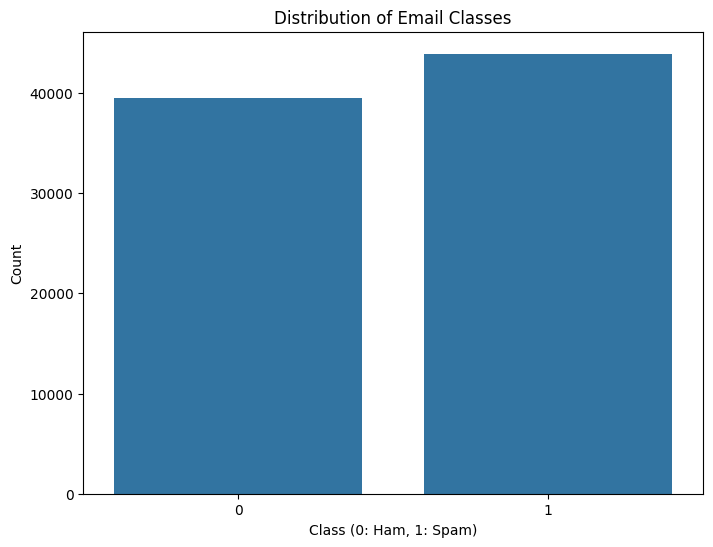

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Email Classes')
plt.xlabel('Class (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.show()

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back to text
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['processed_text'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 83448/83448 [06:15<00:00, 222.14it/s]


## FEATURE ENGINEERING & MODELING

In [ ]:
# Define the subset size as a fraction of the original data
subset_fraction = 0.2  # Using 20% of the original data

# Apply preprocessing only to the subset for now
subset_df = df.sample(frac=subset_fraction, random_state=42)
subset_df['processed_text'] = subset_df['text'].progress_apply(preprocess_text)

100%|██████████| 16690/16690 [01:11<00:00, 233.38it/s]


In [ ]:
X = subset_df['processed_text']
y = subset_df['label']
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 11683 samples
Validation set: 2503 samples
Testing set: 2504 samples


In [ ]:
# Feature extraction using TF-IDF - reduce max_features to speed up further
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))  # Reduced from 5000
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Define models - simplify parameters for faster execution
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),  # Reduced from 100
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500)  # Reduced from 1000
}

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute probabilities for ROC-AUC (if the model supports it)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        # For models that don't have predict_proba
        y_prob = model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [ ]:
# Initialize results dictionary
model_results = {}

# Train and evaluate models
print("Training and evaluating models")
with tqdm(total=len(models), desc="Training and evaluating models", dynamic_ncols=True) as pbar:
    for name, model in models.items():
        tqdm.write(f"Training and evaluating {name}...")
        model_results[name] = evaluate_model(
            model,
            X_train_tfidf,
            X_val_tfidf,
            y_train,
            y_val
        )
        pbar.update(1)

Training and evaluating models


Training and evaluating models:  25%|██▌       | 1/4 [00:00<00:00, 19.31it/s]

Training and evaluating Naive Bayes...
Training and evaluating SVM...


Training and evaluating models:  50%|█████     | 2/4 [01:47<01:47, 53.68s/it]

Training and evaluating Random Forest...


Training and evaluating models: 100%|██████████| 4/4 [01:54<00:00, 28.70s/it]

Training and evaluating Logistic Regression...


In [ ]:
# Display results in a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T
print("\nModel Performance Metrics:")
print(results_df)


Model Performance Metrics:
                     accuracy  precision    recall        f1   roc_auc
Naive Bayes          0.948062   0.941089  0.961158  0.951017  0.989207
SVM                  0.974031   0.968468  0.982483  0.975425  0.996458
Random Forest        0.970036   0.964715  0.978675  0.971645  0.995110
Logistic Regression  0.968038   0.961798  0.977913  0.969789  0.995571


In [ ]:
# Find the best model based on F1 score
best_model_name = results_df['f1'].idxmax()
print(f"\nBest model based on F1 score: {best_model_name}")
print(f"F1 score: {results_df.loc[best_model_name, 'f1']:.4f}")


Best model based on F1 score: SVM
F1 score: 0.9754


In [ ]:
# Retrain best model on combined training and validation data
X_train_val = pd.concat([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
X_train_val_tfidf = vectorizer.fit_transform(X_train_val)
X_test_tfidf = vectorizer.transform(X_test)

best_model.fit(X_train_val_tfidf, y_train_val)
y_pred = best_model.predict(X_test_tfidf)


Final Evaluation on Test Set:
Best Model: SVM
Accuracy: 0.9712
Precision: 0.9648
Recall: 0.9810
F1-Score: 0.9728

Confusion Matrix:


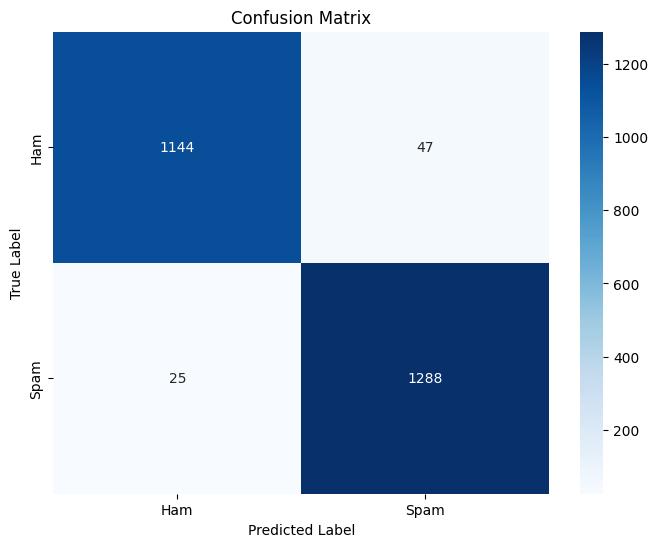


Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.96      0.97      1191
        Spam       0.96      0.98      0.97      1313

    accuracy                           0.97      2504
   macro avg       0.97      0.97      0.97      2504
weighted avg       0.97      0.97      0.97      2504



In [ ]:
# Final evaluation on test set
print("\nFinal Evaluation on Test Set:")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Top 20 important features:
wrote: -5.4068
enron: -5.0526
louis: -3.3730
vinc: -3.2555
samba: -3.0864
thank: -3.0033
debian: -2.9758
doc: -2.9072
perl: -2.8629
http list: -2.8597
daren: -2.6839
houston: -2.5709
org: -2.4691
howstuffwork: -2.4481
list: -2.3940
cc: -2.3830
cnn: -2.3790
schedul: -2.3126
risk: -2.2455
forecast: -2.2080


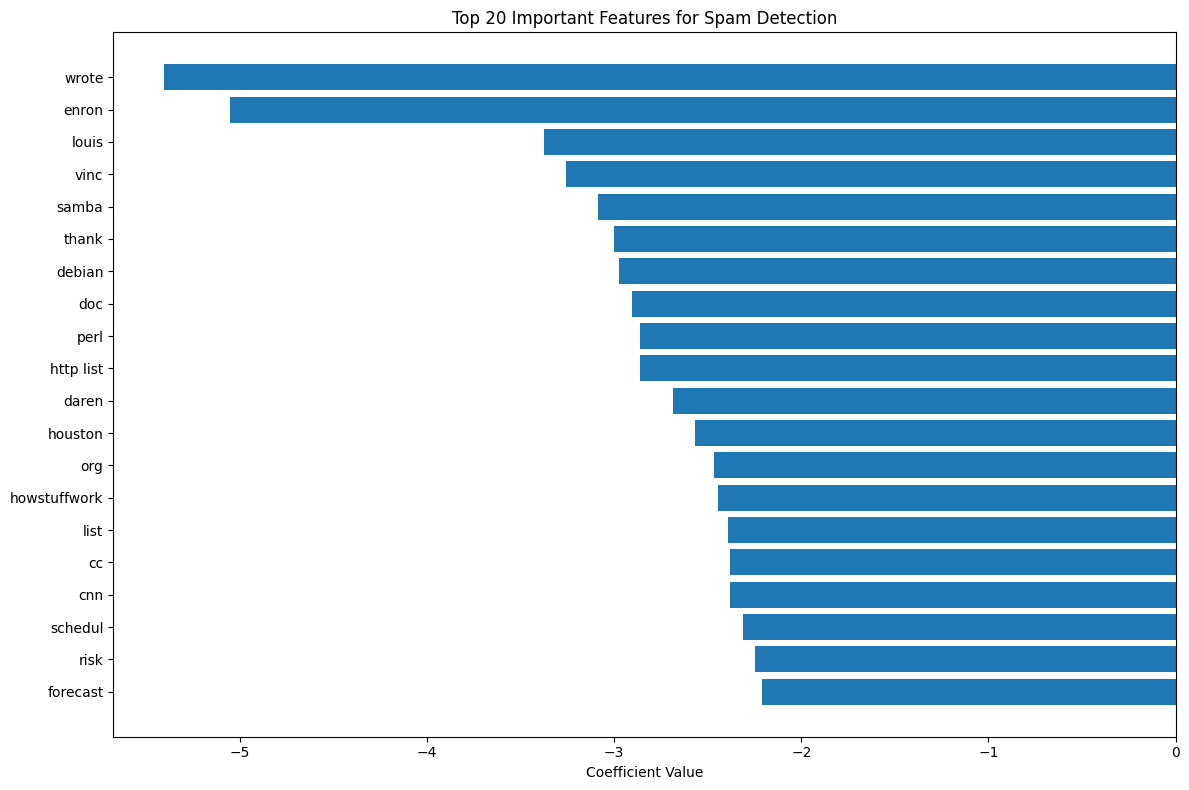

In [ ]:
# Feature importance analysis (for models that support it)

if best_model_name == 'Random Forest':
    # Get feature importances for Random Forest
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = best_model.feature_importances_

    # Sort features by importance
    indices = np.argsort(feature_importance)[::-1]
    top_n = 20

    # Display top N features
    print(f"\nTop {top_n} important features:")
    for i in range(top_n):
        print(f"{feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), feature_importance[indices[:top_n]][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Important Features for Spam Detection')
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Logistic Regression' or best_model_name == 'SVM':
    # Get coefficients for Logistic Regression or SVM with linear kernel
    if hasattr(best_model, 'coef_'):
        feature_names = vectorizer.get_feature_names_out()

        # Convert coefficients to dense array
        if hasattr(best_model.coef_, 'toarray'):
            coefficients = best_model.coef_.toarray()[0]
        else:
            coefficients = best_model.coef_[0]

        # Sort features by absolute coefficient values
        indices = np.argsort(np.abs(coefficients))[::-1]
        top_n = 20

        # Display top N features
        print(f"\nTop {top_n} important features:")
        for i in range(min(top_n, len(indices))):
            coefficient_value = coefficients[indices[i]]
            print(f"{feature_names[indices[i]]}: {coefficient_value:.4f}")

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(range(min(top_n, len(indices))), coefficients[indices[:top_n]][::-1])
        plt.yticks(range(min(top_n, len(indices))), [feature_names[i] for i in indices[:top_n]][::-1])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top {top_n} Important Features for Spam Detection')
        plt.tight_layout()
        plt.show()

In [ ]:
# Sample prediction function
def predict_spam(email_text, model, vectorizer):
    # Preprocess the input text
    processed_text = preprocess_text(email_text)

    # Transform the text into TF-IDF features
    tfidf_features = vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(tfidf_features)[0]

    # Get probability (if applicable)
    try:
        probability = model.predict_proba(tfidf_features)[0][1]
        return prediction, probability
    except:
        # For models without predict_proba
        return prediction, None

In [ ]:
# Test the model with sample emails
sample_emails = [
    "Dear valued customer, Your account has been compromised. Please click the link to verify your identity and reset your password immediately.",
    "Hi John, Just checking if we're still on for tomorrow's meeting at 2pm? Please let me know. Thanks, Mary",
    "CONGRATULATIONS! You've won $1,000,000 in our lottery! To claim your prize, send your bank details and a processing fee of $100.",
    "Meeting agenda for next week: 1. Project updates 2. Budget review 3. New client proposals"
]

print("\nSample Email Predictions:")
for i, email in enumerate(sample_emails):
    prediction, probability = predict_spam(email, best_model, vectorizer)
    label = "Spam" if prediction == 1 else "Ham"
    prob_text = f" (Probability: {probability:.4f})" if probability is not None else ""
    print(f"Email {i+1}: {label}{prob_text}")
    print(f"Text: {email[:100]}..." if len(email) > 100 else f"Text: {email}")
    print("-" * 80)


Sample Email Predictions:
Email 1: Spam (Probability: 0.9964)
Text: Dear valued customer, Your account has been compromised. Please click the link to verify your identi...
--------------------------------------------------------------------------------
Email 2: Ham (Probability: 0.0001)
Text: Hi John, Just checking if we're still on for tomorrow's meeting at 2pm? Please let me know. Thanks, ...
--------------------------------------------------------------------------------
Email 3: Spam (Probability: 1.0000)
Text: CONGRATULATIONS! You've won $1,000,000 in our lottery! To claim your prize, send your bank details a...
--------------------------------------------------------------------------------
Email 4: Ham (Probability: 0.0054)
Text: Meeting agenda for next week: 1. Project updates 2. Budget review 3. New client proposals
--------------------------------------------------------------------------------
